In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_69949/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
from ROOT import *
import time, os, math, sys
from array import array
import argparse

import histoHelpers
from histoHelpers import *

from random import gauss
import numpy as np

import sys

#import sys
sys.path.insert(0,'../../')
from datasets_dijetSel_RunIISummer20UL_SampleDictPrep import dictSamples, checkDict


sys.path.insert(0,'../python/')
import CMS_lumi as CMS_lumi
import tdrstyle as tdrstyle
from collections import OrderedDict

import json
import gc
import copy
import pprint

Welcome to JupyROOT 6.24/06


In [3]:
tdrstyle.setTDRStyle()
gROOT.SetBatch()
gROOT.ForceStyle()
tdrstyle.setTDRStyle()
ROOT.gStyle.SetOptFit(1)
ROOT.gStyle.SetOptStat(0)

#CMS_lumi.lumi_7TeV = "4.8 fb^{-1}"
#CMS_lumi.lumi_8TeV = "18.3 fb^{-1}"
CMS_lumi.writeExtraText = True
CMS_lumi.extraText = "Preliminary"

CMS_lumi.lumi_13TeV = "2017 (13 TeV)"#%np.round(lumi/1000.0,3)
#CMS_lumi.lumi_sqrtS = "%.2f fb^{-1} (13 TeV)"%np.round(lumi/1000,3)

CMS_lumi.relPosX = 0.1

iPos = 0
#if( iPos==0 ): CMS_lumi.relPosX = 0.16


#c = np.zeros(len(Range_WSel), ROOT.TCanvas)
#l = np.zeros(len(Range_WSel), ROOT.TLegend)

H_ref = 720; 
W_ref = 1024; 
W = W_ref
H  = H_ref

iPeriod = 4

# references for T, B, L, R
T = 0.08*H_ref
B = 0.12*H_ref 
L = 0.12*W_ref
R = 0.04*W_ref

x1_l = 0.9
y1_l = 0.9

dx_l = 0.25
dy_l = 0.25
x0_l = x1_l-dx_l
y0_l = y1_l-dy_l

In [4]:
inFileSample=ROOT.TFile.Open('../TrigEff_Plots/triggerEfficiencies_histograms_MiniAOD_JetHTRun2017ALL_eta2pt4.root','r')
sample='JetHT2017'


triggerDenomList=['AK8PFJet500','AK8PFJet450','AK8PFJet400','AK8PFJet320','AK8PFJet260','AK8PFJet200','AK8PFJet140','AK8PFJet80','AK8PFJet60']
#denomScale=5.404#16419.911 
triggerPassList=['AK8PFJet550','AK8PFJet500','AK8PFJet450','AK8PFJet400','AK8PFJet320','AK8PFJet260','AK8PFJet200','AK8PFJet140','AK8PFJet80'] 
#passScale=0.0085
nameList=['AK8PFJet550','AK8PFJet500','AK8PFJet450','AK8PFJet400','AK8PFJet320','AK8PFJet260','AK8PFJet200','AK8PFJet140','AK8PFJet80'] 
prescale=[1.,1.,4.292088778836935,5.393065983392267,33.804773113717694,88.36541861931303,219.49912116362435,1559.144327091228,16410.00511811854] 
minFit=100 
maxFit=1000 
xlabel='Leading jet pt [GeV]' 
xmin=100 
xmax=2000 
rebin=1 
log=True
calcType='simulated' 
version='CheckV1'
ext='png'
lumi=41.47


triggerDict = OrderedDict()
for it,ipresc in zip(nameList,prescale):
    triggerDict[it]=dict()
    triggerDict[it]['threshold'] = it.split('PFJet')[1]
    triggerDict[it]['prescale'] = ipresc
    triggerDict[it]['luminosity'] = lumi/ipresc
    triggerDict[it]['turn-on_1'] = 0.
    triggerDict[it]['turn-on_2'] = 0.
    

In [5]:
pprint.pprint(triggerDict)

OrderedDict([('AK8PFJet550',
              {'luminosity': 41.47,
               'prescale': 1.0,
               'threshold': '550',
               'turn-on_1': 0.0,
               'turn-on_2': 0.0}),
             ('AK8PFJet500',
              {'luminosity': 41.47,
               'prescale': 1.0,
               'threshold': '500',
               'turn-on_1': 0.0,
               'turn-on_2': 0.0}),
             ('AK8PFJet450',
              {'luminosity': 9.661962307135102,
               'prescale': 4.292088778836935,
               'threshold': '450',
               'turn-on_1': 0.0,
               'turn-on_2': 0.0}),
             ('AK8PFJet400',
              {'luminosity': 7.689503545423924,
               'prescale': 5.393065983392267,
               'threshold': '400',
               'turn-on_1': 0.0,
               'turn-on_2': 0.0}),
             ('AK8PFJet320',
              {'luminosity': 1.2267498397488672,
               'prescale': 33.804773113717694,
               'thresho

In [6]:
%jsroot on

In [7]:
for triggerPass,triggerDenom,name in zip(triggerPassList,triggerDenomList,nameList):
    xline = array('d', [0,2000])
    yline = array('d', [0.99,.99])
    line = TGraph(2, xline, yline)
    line.SetLineColor(ROOT.kCyan)
    #line.SetLineWidth(1)
    #line.SetLineStyle(2)
    outputFileName = name+'_'+triggerDenom+"_"+triggerPass+'_'+sample+'_TriggerEfficiency'+version+'.'+ext
    print (f'Processing.......{outputFileName} for {triggerPass,triggerDenom,name}')


    threshold = int(triggerPass.split('AK8PFJet')[1])
    
    can = TCanvas('c'+triggerPass, 'c'+triggerPass,W,H)
    can.SetTicks(1)
    can.SetFillColor(0)
    can.SetBorderMode(0)
    can.SetBorderSize(0)
    can.SetFrameFillStyle(0)
    can.SetFrameBorderMode(0)
    #can.SetFrameLineWidth(0)
    can.SetLeftMargin( L/W )
    can.SetRightMargin( R/W )
    can.SetTopMargin( T/H )
    can.SetBottomMargin( B/H )
    can.SetTickx(0)
    can.SetTicky(0)
    #can.cd()

    can.cd()


    histos={}
    histos[ 'denomOnly'+triggerPass ] = inFileSample.Get( 'TriggerEfficiencies/jet1Pt_'+triggerDenom+'_only' ).Clone()
    #histos[ 'denomOnly'+triggerPass ].Scale(triggerDict[triggerDenom]['prescale'])
    histos[ 'PassingOnly'+triggerPass ] = inFileSample.Get( 'TriggerEfficiencies/jet1Pt_'+triggerPass+'_simulated' ).Clone()
    #histos[ 'PassingOnly'+triggerPass ].Scale(triggerDict[triggerPass]['prescale'])


    histos[ 'denomOnly'+triggerPass ].Rebin(rebin)
    histos[ 'PassingOnly'+triggerPass ].Rebin(rebin)
    binWidth = histos[ 'denomOnly'+triggerPass ].GetBinWidth(1)

    histos[ 'denomOnly'+triggerPass ].SetLineWidth(2)
    histos[ 'denomOnly'+triggerPass ].SetLineColor(kGray)

    histos[ 'eff'+triggerPass ] = histos[ 'PassingOnly'+triggerPass ].Clone("Efficiency")#ROOT.TEfficiency( histos[ 'PassingOnly'+triggerPass ].Clone(), histos[ 'denomOnly'+triggerPass ].Clone() )
    histos[ 'eff'+triggerPass ].Divide(histos[ 'denomOnly'+triggerPass ])


    histos[ 'eff'+triggerPass ].SetMarkerStyle(20)
    histos[ 'eff'+triggerPass ].SetMaximum(2.)
    histos[ 'eff'+triggerPass ].SetMinimum(0.)
    histos[ 'eff'+triggerPass ].GetXaxis().SetRangeUser(0, min(6*threshold, 2000))
    #histos[ 'eff'+triggerPass ].SetTitleOffset(1.3,'X')
    
    title = f'{triggerPass} relative to {triggerDenom}'    
    histos[ 'eff'+triggerPass ].SetTitle(title+"; Leading jet p_{T} [GeV]; Efficiency (#epsilon)")
    histos[ 'eff'+triggerPass ].GetYaxis().CenterTitle()
    histos[ 'eff'+triggerPass ].GetYaxis().SetTitleSize(0.06)
    histos[ 'eff'+triggerPass ].GetXaxis().SetTitleSize(0.05)
    histos[ 'eff'+triggerPass ].GetYaxis().SetTitleOffset(0.9)
    histos[ 'eff'+triggerPass ].GetXaxis().SetTitleOffset(1.15)
    histos[ 'eff'+triggerPass ].Draw()
    
    #histos[ 'eff'+triggerPass ].Draw()
    # Fit to obtain turn-ons

    #lower_threshold = int(triggerPass.split('AK8PFJet')[1])*1.2
    lower_threshold = int(triggerPass.split('AK8PFJet')[1])/1.2
    higher_threshold = int(triggerPass.split('AK8PFJet')[1])*5.

    print(triggerPass,triggerPass.split('AK8PFJet')[1],lower_threshold,higher_threshold)

    fit = ROOT.TF1("eff_%s" % name, '[3]*([0] + 0.5 * (1-[0]) * (1 + erf((x-[1])/[2])))', lower_threshold, higher_threshold)
    # set parameter names
    fit.SetParName(0, 'a')
    fit.SetParName(1, 'mu')
    fit.SetParName(2, 'sigma')
    fit.SetParName(3, 'N')
    # set parameter limits
    fit.SetParLimits(1, lower_threshold, higher_threshold)  # enforce +ve parameter values
    fit.SetParLimits(1, 1, 1000)  # enforce +ve parameter values
    fit.SetParLimits(2, 20, 500)
    # fit.SetParLimits(3, 0.00001, 100)
    fit.SetParLimits(3, 0.9, 1.1)
    fit.SetLineColor(ROOT.kBlack)
    fit.SetLineWidth(1)
    # Set starting values
    fit.SetParameter('a', 0)
    fit.SetParameter('mu', int(triggerPass.split('AK8PFJet')[1]))
    fit.SetParameter('sigma', int(triggerPass.split('AK8PFJet')[1])/10)
    fit.SetParameter('N', 1)
    fit.SetNpx(5000)
    fit.SetLineColor(ROOT.kRed)
    #fit.SetLineWidth(1)
    fit_result = histos[ 'eff'+triggerPass ].Fit(fit, 'RSE')
    histos[ 'eff'+triggerPass ].Draw()
    
    #cl1=histos[ 'PassingOnly'+triggerPass ].Clone()
    #cl2=histos[ 'denomOnly'+triggerPass ].Clone()
    #cl1.Scale(20./cl1.Integral())
    #cl2.Scale(20./cl2.Integral())
    #cl1.Draw("hist same")
    #cl2.Draw("hist same")
    
    ROOT.gPad.Modified()
    ROOT.gPad.Update()
    
    
    # Draw fit stats
    stats_box = histos[ 'eff'+triggerPass ].FindObject("stats")
    stats_box.SetFillColor(ROOT.kWhite)
    stats_box.SetBorderSize(0)
    stats_box.SetFillStyle(0)
    stats_box.SetX1NDC(0.62)
    stats_box.SetX2NDC(0.88)
    stats_box.SetY1NDC(0.75)
    stats_box.SetY2NDC(0.88)
    #line.Draw("same")
    CMS_lumi.CMS_lumi(can, iPeriod, iPos)
    can.cd()
    can.Update()
    can.RedrawAxis()
    frame = can.GetFrame()
    frame.Draw()
    

    # Add in info about 99% relative efficiency
    good_eff = 0.99 * fit.GetParameter("N")
    good_eff_pt = fit.GetX(good_eff)
    #info['good_eff_pt'] = good_eff_pt
    #info['good_eff_pt_err'] = 0
    print(good_eff_pt,triggerPass)
    eff_text = ROOT.TPaveText(0.63, 0.65, 0.88, 0.73, "NDC")
    eff_text.AddText("#epsilon = 0.99 #times %.3f" % fit.GetParameter("N"))
    eff_text.AddText("@ p_{T} = %3.f GeV" % good_eff_pt)
    eff_text.SetFillStyle(0)
    eff_text.SetBorderSize(0)
    eff_text.SetTextAlign(ROOT.kHAlignLeft + ROOT.kVAlignBottom)
    eff_text.Draw()
    
    
    triggerDict[triggerPass]['turn-on_1'] = good_eff_pt
    
    extra = ROOT.TPaveText(0.32,0.8,0.77,1.1, "brNDC")
    extra.SetTextSize(0.037)
    extra.AddText(title)
    extra.SetFillColor(0)
    extra.SetBorderSize(0)
    extra.Draw()
    
    can.Update()
    can.Draw()
    #input("Press Enter to end")
    can.SaveAs(outputFileName)
    can.Close()

Processing.......AK8PFJet550_AK8PFJet500_AK8PFJet550_JetHT2017_TriggerEfficiencyCheckV1.png for ('AK8PFJet550', 'AK8PFJet500', 'AK8PFJet550')
AK8PFJet550 550 458.33333333333337 2750.0
650.642245151608 AK8PFJet550
Processing.......AK8PFJet500_AK8PFJet450_AK8PFJet500_JetHT2017_TriggerEfficiencyCheckV1.png for ('AK8PFJet500', 'AK8PFJet450', 'AK8PFJet500')
AK8PFJet500 500 416.6666666666667 2500.0
593.7850246114499 AK8PFJet500
Processing.......AK8PFJet450_AK8PFJet400_AK8PFJet450_JetHT2017_TriggerEfficiencyCheckV1.png for ('AK8PFJet450', 'AK8PFJet400', 'AK8PFJet450')
AK8PFJet450 450 375.0 2250.0
541.404363904982 AK8PFJet450
Processing.......AK8PFJet400_AK8PFJet320_AK8PFJet400_JetHT2017_TriggerEfficiencyCheckV1.png for ('AK8PFJet400', 'AK8PFJet320', 'AK8PFJet400')
AK8PFJet400 400 333.33333333333337 2000.0
493.59323024787085 AK8PFJet400
Processing.......AK8PFJet320_AK8PFJet260_AK8PFJet320_JetHT2017_TriggerEfficiencyCheckV1.png for ('AK8PFJet320', 'AK8PFJet260', 'AK8PFJet320')
AK8PFJet320 320 2

In [8]:
inFileSample.Close()
inFileSample=ROOT.TFile.Open('../TrigEff_Plots/triggerEfficiencies_histograms_MiniAOD_JetHTRun2017ALL_eta2pt4.root','r')


In [9]:
for triggerPass,triggerDenom,name in zip(triggerPassList,triggerDenomList,nameList):
    xline = array('d', [0,2000])
    yline = array('d', [0.99,.99])
    line = TGraph(2, xline, yline)
    line.SetLineColor(ROOT.kCyan)
    #line.SetLineStyle(2)
    outputFileName = name+'_'+triggerDenom+"_"+triggerPass+'_'+sample+'_TriggerEfficiency'+version+'_FinerFit.'+ext
    print (f'Processing.......{outputFileName} for {triggerPass,triggerDenom,name}')


    threshold = int(triggerPass.split('AK8PFJet')[1])
    
    can = TCanvas('c2'+triggerPass, 'c2'+triggerPass,W,H)
    can.SetTicks(1)
    can.SetFillColor(0)
    can.SetBorderMode(0)
    can.SetBorderSize(0)
    can.SetFrameFillStyle(0)
    can.SetFrameBorderMode(0)
    #can.SetFrameLineWidth(0)
    can.SetLeftMargin( L/W )
    can.SetRightMargin( R/W )
    can.SetTopMargin( T/H )
    can.SetBottomMargin( B/H )
    can.SetTickx(0)
    can.SetTicky(0)
    #can.cd()

    can.cd()


    histos={}
    histos[ 'denomOnly'+triggerPass ] = inFileSample.Get( 'TriggerEfficiencies/jet1Pt_'+triggerDenom+'_only' ).Clone()
    #histos[ 'denomOnly'+triggerPass ].Scale(triggerDict[triggerDenom]['prescale'])
    histos[ 'PassingOnly'+triggerPass ] = inFileSample.Get( 'TriggerEfficiencies/jet1Pt_'+triggerPass+'_simulated' ).Clone()
    #histos[ 'PassingOnly'+triggerPass ].Scale(triggerDict[triggerPass]['prescale'])


    histos[ 'denomOnly'+triggerPass ].Rebin(rebin)
    histos[ 'PassingOnly'+triggerPass ].Rebin(rebin)
    binWidth = histos[ 'denomOnly'+triggerPass ].GetBinWidth(1)

    histos[ 'denomOnly'+triggerPass ].SetLineWidth(2)
    histos[ 'denomOnly'+triggerPass ].SetLineColor(kGray)

    histos[ 'eff'+triggerPass ] = histos[ 'PassingOnly'+triggerPass ].Clone("Efficiency")#ROOT.TEfficiency( histos[ 'PassingOnly'+triggerPass ].Clone(), histos[ 'denomOnly'+triggerPass ].Clone() )
    histos[ 'eff'+triggerPass ].Divide(histos[ 'denomOnly'+triggerPass ])


    histos[ 'eff'+triggerPass ].SetMarkerStyle(8)
    histos[ 'eff'+triggerPass ].SetMaximum(2.)
    histos[ 'eff'+triggerPass ].SetMinimum(0.)
    histos[ 'eff'+triggerPass ].GetXaxis().SetRangeUser(0, min(6*threshold, 2000))
    #histos[ 'eff'+triggerPass ].SetTitleOffset(1.3,'X')
    
    title = f'{triggerPass} relative to {triggerDenom}'    
    histos[ 'eff'+triggerPass ].SetTitle(title+"; Leading jet p_{T} [GeV]; Efficiency (#epsilon)")
    histos[ 'eff'+triggerPass ].GetYaxis().CenterTitle()
    histos[ 'eff'+triggerPass ].GetYaxis().SetTitleSize(0.06)
    histos[ 'eff'+triggerPass ].GetXaxis().SetTitleSize(0.05)
    histos[ 'eff'+triggerPass ].GetYaxis().SetTitleOffset(0.9)
    histos[ 'eff'+triggerPass ].GetXaxis().SetTitleOffset(1.15)
    histos[ 'eff'+triggerPass ].Draw()
    
    #histos[ 'eff'+triggerPass ].Draw()
    # Fit to obtain turn-ons

    #lower_threshold = int(triggerPass.split('AK8PFJet')[1])*1.2
    lower_threshold = int(triggerPass.split('AK8PFJet')[1])/1.2
    higher_threshold = int(triggerPass.split('AK8PFJet')[1])*5.

    print(triggerPass,triggerPass.split('AK8PFJet')[1],lower_threshold,higher_threshold)

    fit = ROOT.TF1("eff_%s" % name, '[3]*([0] + 0.5 * (1-[0]) * (1 + erf((x-[1])/[2])))', lower_threshold, higher_threshold)
    # set parameter names
    fit.SetParName(0, 'a')
    fit.SetParName(1, 'mu')
    fit.SetParName(2, 'sigma')
    fit.SetParName(3, 'N')
    # set parameter limits
    fit.SetParLimits(1, lower_threshold, higher_threshold)  # enforce +ve parameter values
    fit.SetParLimits(1, 1, 1000)  # enforce +ve parameter values
    fit.SetParLimits(2, 20, 500)
    # fit.SetParLimits(3, 0.00001, 100)
    fit.SetParLimits(3, 0.9, 1.1)
    fit.SetLineColor(ROOT.kBlack)
    fit.SetLineWidth(1)
    # Set starting values
    fit.SetParameter('a', 0)
    fit.SetParameter('mu', int(triggerPass.split('AK8PFJet')[1]))
    fit.SetParameter('sigma', int(triggerPass.split('AK8PFJet')[1])/10)
    fit.SetParameter('N', 1)
    fit.SetNpx(5000)
    fit.SetLineColor(ROOT.kRed)
    fit_result = histos[ 'eff'+triggerPass ].Fit(fit, 'RSE')
    histos[ 'eff'+triggerPass ].Draw()
    
    #cl1=histos[ 'PassingOnly'+triggerPass ].Clone()
    #cl2=histos[ 'denomOnly'+triggerPass ].Clone()
    #cl1.Scale(20./cl1.Integral())
    #cl2.Scale(20./cl2.Integral())
    #cl1.Draw("hist same")
    #cl2.Draw("hist same")
    
    ROOT.gPad.Modified()
    ROOT.gPad.Update()
    
    
            
    # Update fit by increasing starting point to better capture effects in the high efficiency region
    fit_factor = 0.95 
    fit.SetRange(fit.GetX(fit_factor*fit.GetParameter("N")), higher_threshold*1.)
    fit_result = histos[ 'eff'+triggerPass ].Fit(fit, 'RSEMQ')
    ROOT.gPad.Modified()
    ROOT.gPad.Update()
    #fit_result.Draw()#histos[ 'eff'+triggerPass ].Draw()
    # Draw fit stats
    stats_box = histos[ 'eff'+triggerPass ].FindObject("stats")
    stats_box.SetFillColor(ROOT.kWhite)
    stats_box.SetBorderSize(0)
    stats_box.SetFillStyle(0)
    stats_box.SetX1NDC(0.62)
    stats_box.SetX2NDC(0.88)
    stats_box.SetY1NDC(0.75)
    stats_box.SetY2NDC(0.88)
    #line.Draw("same")
    CMS_lumi.CMS_lumi(can, iPeriod, iPos)
    can.cd()
    can.Update()
    can.RedrawAxis()
    frame = can.GetFrame()
    frame.Draw()
    

    # Add in info about 99% relative efficiency
    good_eff = 0.99 * fit.GetParameter("N")
    good_eff_pt = fit.GetX(good_eff)
    #info['good_eff_pt'] = good_eff_pt
    #info['good_eff_pt_err'] = 0
    print(good_eff_pt,triggerPass)
    eff_text = ROOT.TPaveText(0.63, 0.65, 0.88, 0.73, "NDC")
    eff_text.AddText("#epsilon = 0.99 #times %.3f" % fit.GetParameter("N"))
    eff_text.AddText("@ p_{T} = %3.f GeV" % good_eff_pt)
    eff_text.SetFillStyle(0)
    eff_text.SetBorderSize(0)
    eff_text.SetTextAlign(ROOT.kHAlignLeft + ROOT.kVAlignBottom)
    eff_text.Draw()
    
    
    extra = ROOT.TPaveText(0.32,0.8,0.77,1.1, "brNDC")
    extra.SetTextSize(0.037)
    extra.AddText(title)
    extra.SetFillColor(0)
    extra.SetBorderSize(0)
    extra.Draw()
    triggerDict[triggerPass]['turn-on_2'] = good_eff_pt

    can.Update()
    can.Draw()
    #input("Press Enter to end")
    can.SaveAs(outputFileName)
    can.Close()

Processing.......AK8PFJet550_AK8PFJet500_AK8PFJet550_JetHT2017_TriggerEfficiencyCheckV1_FinerFit.png for ('AK8PFJet550', 'AK8PFJet500', 'AK8PFJet550')
AK8PFJet550 550 458.33333333333337 2750.0
677.3484729747621 AK8PFJet550
Processing.......AK8PFJet500_AK8PFJet450_AK8PFJet500_JetHT2017_TriggerEfficiencyCheckV1_FinerFit.png for ('AK8PFJet500', 'AK8PFJet450', 'AK8PFJet500')
AK8PFJet500 500 416.6666666666667 2500.0
621.2568987444563 AK8PFJet500
Processing.......AK8PFJet450_AK8PFJet400_AK8PFJet450_JetHT2017_TriggerEfficiencyCheckV1_FinerFit.png for ('AK8PFJet450', 'AK8PFJet400', 'AK8PFJet450')
AK8PFJet450 450 375.0 2250.0
564.8755499178139 AK8PFJet450
Processing.......AK8PFJet400_AK8PFJet320_AK8PFJet400_JetHT2017_TriggerEfficiencyCheckV1_FinerFit.png for ('AK8PFJet400', 'AK8PFJet320', 'AK8PFJet400')
AK8PFJet400 400 333.33333333333337 2000.0
515.2032187699662 AK8PFJet400
Processing.......AK8PFJet320_AK8PFJet260_AK8PFJet320_JetHT2017_TriggerEfficiencyCheckV1_FinerFit.png for ('AK8PFJet320', '

In [10]:
import mplhep as hep
import matplotlib.pyplot as plt
hep.style.use("CMS")
%matplotlib inline
def do_fit(x,y,):
    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef) 
    return poly1d_fn

[80, 140, 200, 260, 320, 400, 450, 500, 550] [138.41448107471038, 202.54413764052882, 273.846158931775, 338.5648157427782, 406.0975361408769, 493.59323024787085, 541.404363904982, 593.7850246114499, 650.642245151608] [140.89257439071253, 212.42771187488103, 282.89367284482165, 351.9574864638312, 422.1915372269719, 515.2032187699662, 564.8755499178139, 621.2568987444563, 677.3484729747621]
 
1.087 x + 53.97  
1.139 x + 53.88
[140.95432277 206.19202245 271.42972214 336.66742182 401.90512151
 488.88872109 543.25347082 597.61822056 651.9829703 ] [145.03169962 213.39211687 281.75253412 350.11295136 418.47336861
 509.6205916  566.58760597 623.55462034 680.52163471]


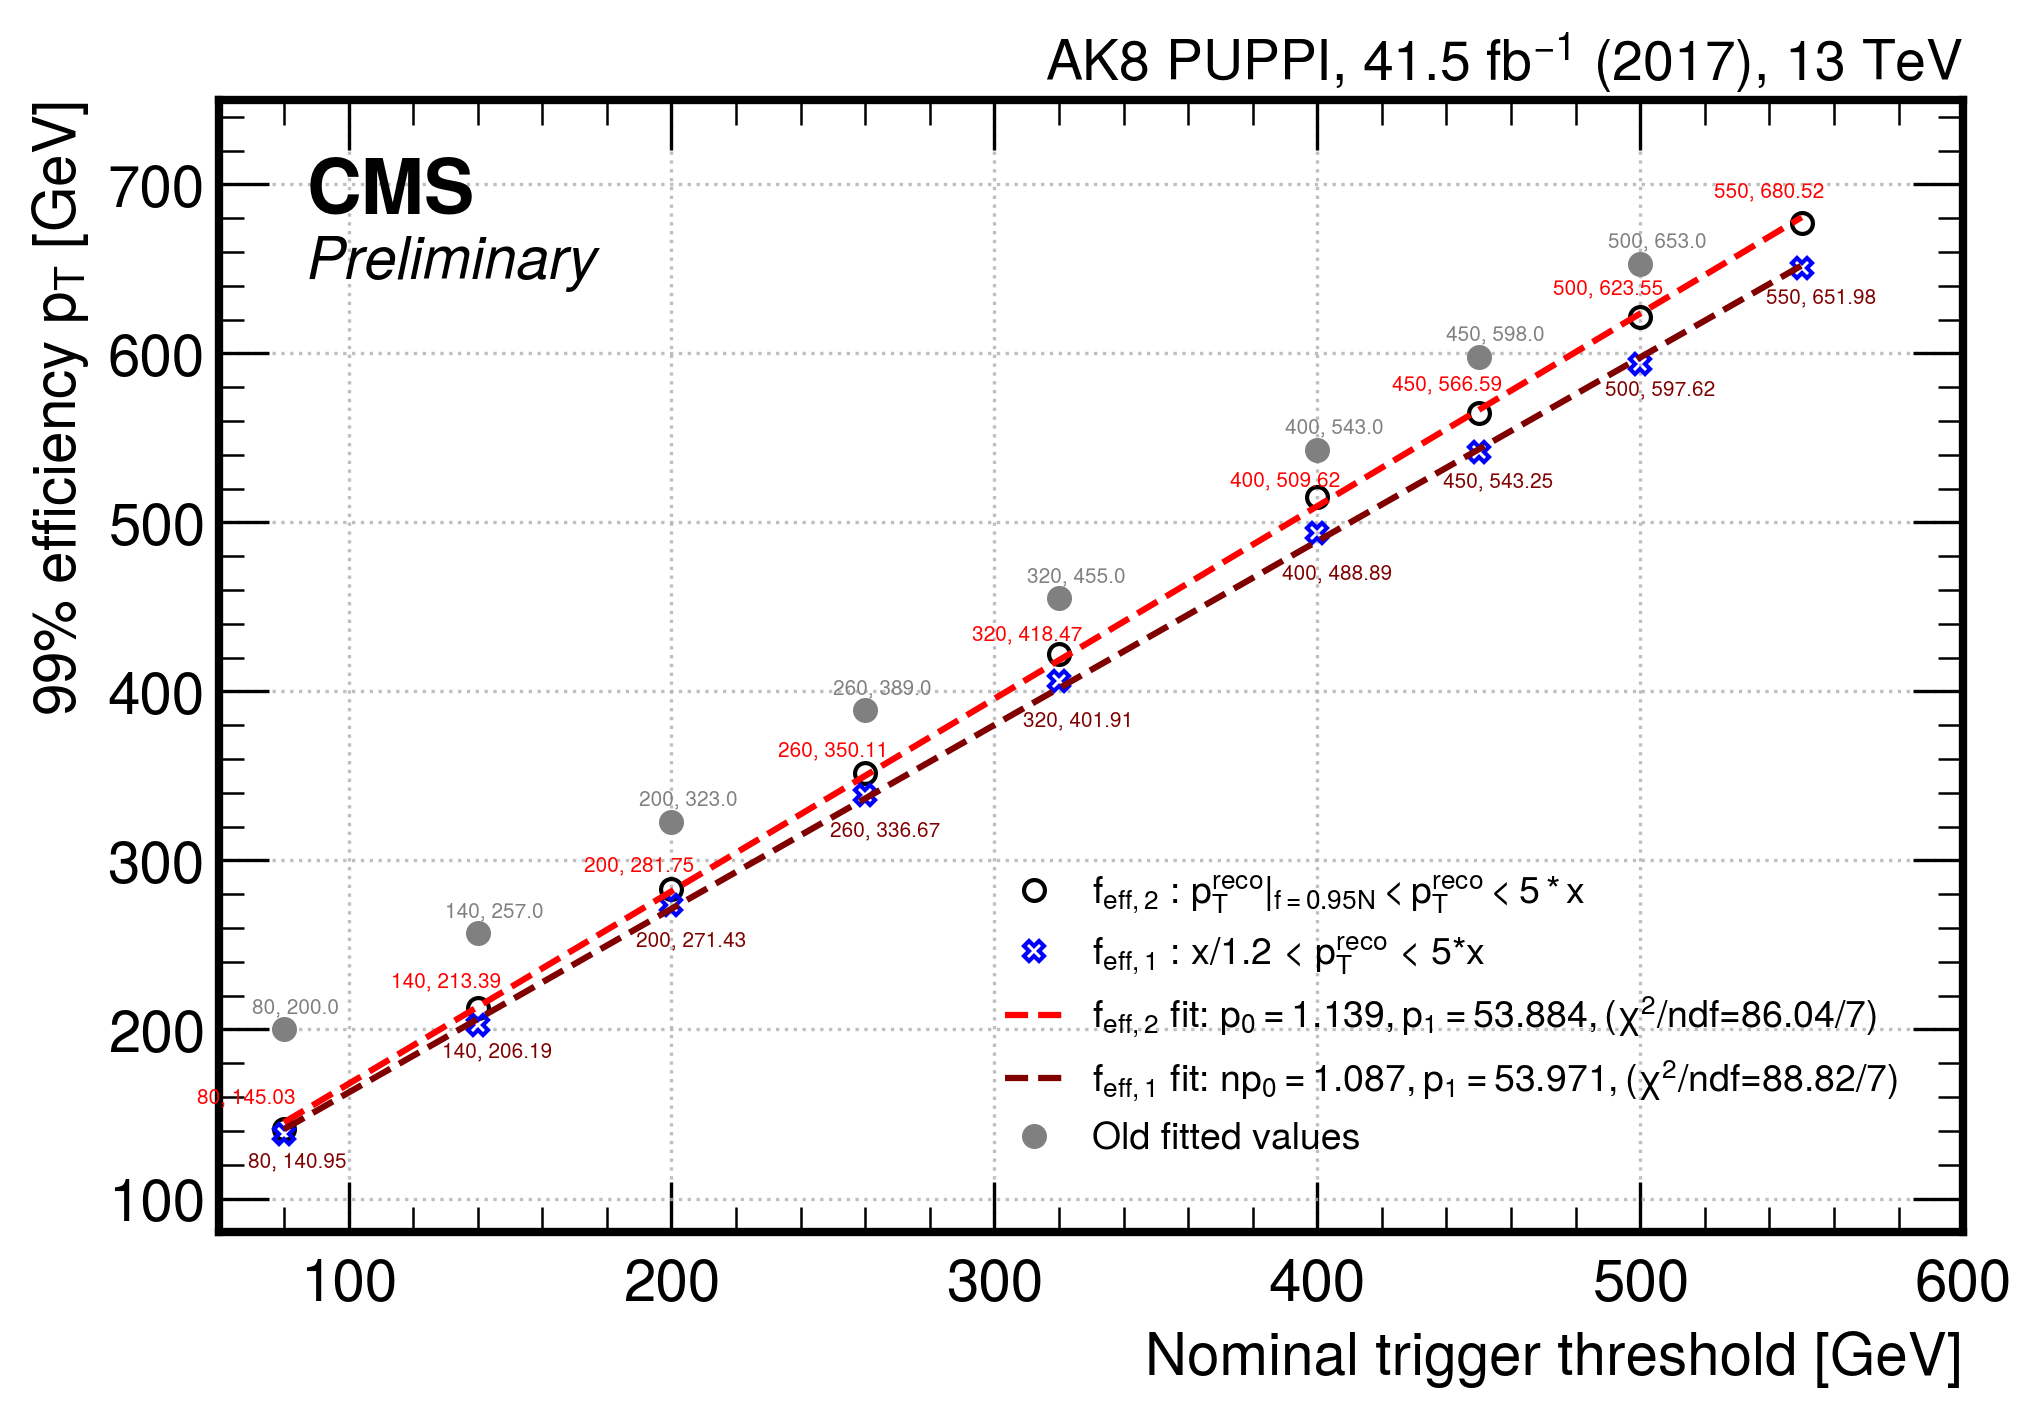

In [12]:
fig, ax = plt.subplots(figsize=(7.5,5),dpi=300)#300)

turnon_1 = []
turnon_2 = []
thresholds = []
for it in reversed(triggerDict.keys()):
    turnon_1.append(triggerDict[it]['turn-on_1'])
    turnon_2.append(triggerDict[it]['turn-on_2'])
    thresholds.append(int(triggerDict[it]['threshold']))
    #
print(thresholds,turnon_1,turnon_2)
    
plt.plot(thresholds[:],turnon_2[:],'ko',label=r'$f_{eff,2}$ : $p_T^{reco}|_{f=0.95N} <p_T^{reco} < 5*x$',markersize=5,markerfacecolor='none')
plt.plot(thresholds[:],turnon_1[:],'bX',label=r'$f_{eff,1}$ : x/1.2 < $p_T^{reco}$ < 5*x',markersize=5,markerfacecolor='none')

y1, r1, *_ = np.polyfit(thresholds[:],turnon_1[:],1,full=True)
y2, r2, *_ = np.polyfit(thresholds[:],turnon_2[:],1,full=True)

fit1 = np.poly1d(y1)
fit2 = np.poly1d(y2)

plt.plot(thresholds[:],fit2(thresholds[:]),'r--',
         label=r'$f_{eff,2}$'+f" fit: $p_0={y2[0]:0.3f},p_1={y2[1]:0.3f},(\chi^2/ndf$={r2[0]:0.2f}/{len(thresholds[:])-1-1})")
plt.plot(thresholds[:],fit1(thresholds[:]),'--',color='maroon',
         label=r'$f_{eff,1}$'+f" fit: n$p_0={y1[0]:0.3f},p_1={y1[1]:0.3f},(\chi^2/ndf$={r1[0]:0.2f}/{len(thresholds[:])-1-1})")

plt.plot(thresholds[:-1],[200.,257.,323.,389.,455.,543.,598.,653.],'o',color='gray',label='Old fitted values',markersize=5)

for x,y in zip(thresholds[:],fit1(thresholds[:])):
    plt.text(x-11,y-22,f'{str(x)}, {str(np.round(y,2))}', color='maroon', fontsize=5)

for x,y in zip(thresholds[:],fit2(thresholds[:])):
    plt.text(x-27,y+12,f'{str(x)}, {str(np.round(y,2))}', color='red', fontsize=5)

for x,y in zip(thresholds[:-1],[200.,257.,323.,389.,455.,543.,598.,653.]):
    plt.text(x-10,y+10,f'{str(x)}, {str(np.round(y,2))}', color='gray', fontsize=5)

print(fit1,fit2)
print(fit1(thresholds[:]),fit2(thresholds[:]))

#plt.plot(thresholds,turnon_2,label='Fit 2',marker='bo',ls='' )
hep.cms.lumitext(r"AK8 PUPPI, 41.5 fb$^{-1}$ (2017), 13 TeV",fontsize=14)
hep.cms.text(r"Preliminary",fontsize=14,loc=2)
ax.legend(fontsize=9,loc=(0.44,0.05))
ax.set_xlabel(r'Nominal trigger threshold [GeV]', loc='right',fontsize=14)
ax.set_ylabel(r'99% efficiency $p_T$ [GeV]', loc='top',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)#plt.yscale('log')

plt.ylim(80.,750.)
plt.xlim(60.,600.)
plt.grid(200)
plt.savefig('TriggerThresholds_vs_99pc_pT_UL17.png')
plt.savefig('TriggerThresholds_vs_99pc_pT_UL17.pdf')